In [134]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

import sys

from tqdm.autonotebook import tqdm

sys.path.append('../')

from plot_helper import plot_image, plot_coco
from pycocotools.coco import COCO

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [135]:
coco_train = COCO('/home/ishvlad/datasets/LV-MHP-v2/train/COCO-annotation.json')
coco_val = COCO('/home/ishvlad/datasets/LV-MHP-v2/val/COCO-annotation.json')

loading annotations into memory...
Done (t=0.56s)
creating index...
index created!
loading annotations into memory...
Done (t=0.50s)
creating index...
index created!


## plot samples

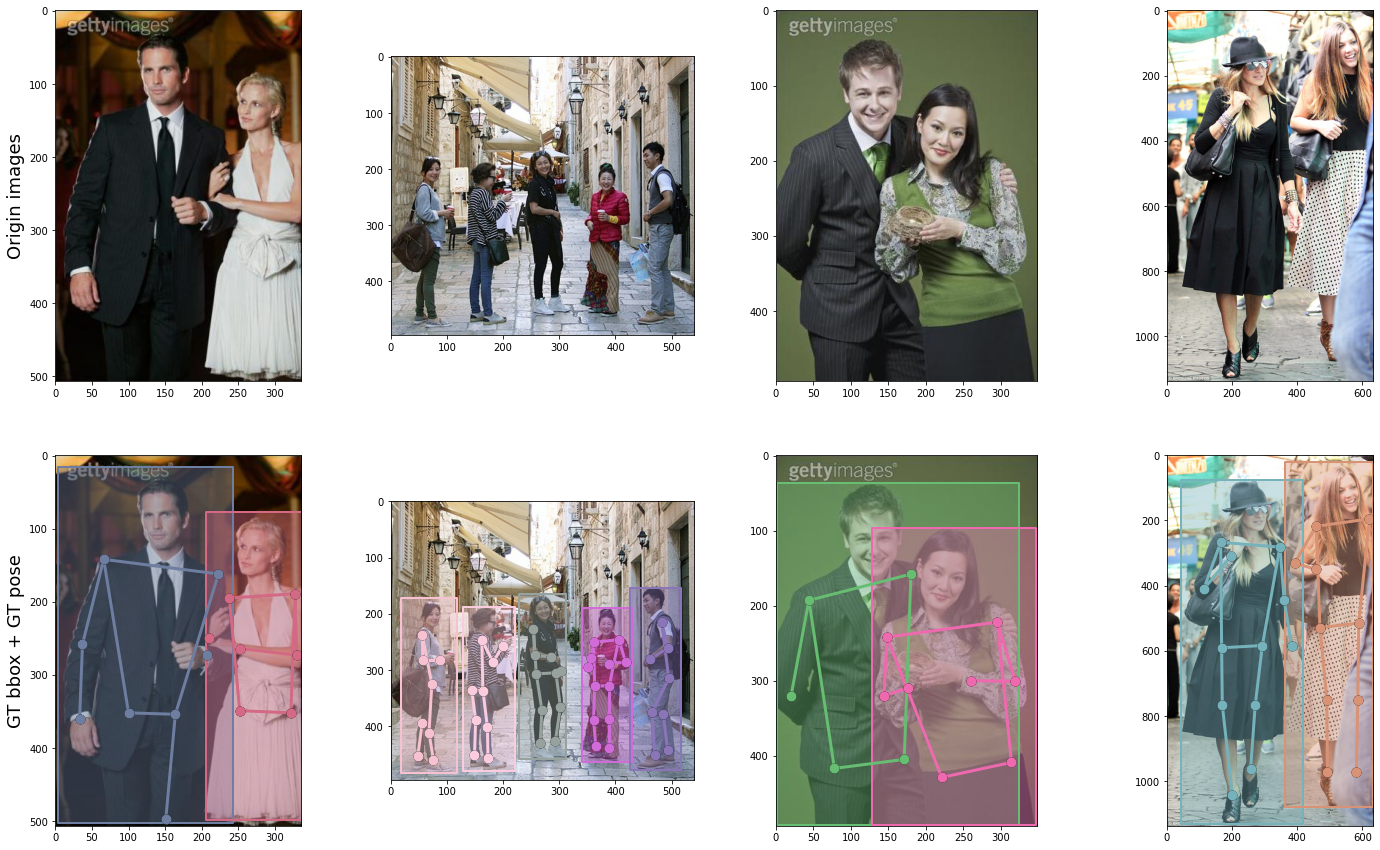

In [136]:
import numpy as np
import matplotlib.pyplot as plt

n_show = 4
fontsize=18

plt.figure(figsize=(25,15))
for i, image_id in enumerate(np.random.choice(coco_train.getImgIds(), n_show)):

    plt.subplot(2, n_show, i + 1)
    plot_image(image_id, data_path='/home/ishvlad/datasets/LV-MHP-v2/train/')
    if i == 0:
        plt.ylabel('Origin images', fontsize=fontsize)

    plt.subplot(2, n_show, n_show + i + 1)
    plot_coco(coco_train, image_id, data_path='/home/ishvlad/datasets/LV-MHP-v2/train/')
    if i == 0:
        plt.ylabel('GT bbox + GT pose', fontsize=fontsize)

In [137]:
# sample: bbox
# fields: image_id, num_kps, has_face, has_lower_kps
def process_coco(coco):
    buffer = []
    for anno in tqdm(coco.anns.values()):
        kps = np.array(anno['keypoints']).reshape(-1, 3)
        buffer.append({
            'image_id': anno['image_id'],
            'num_kps': sum(kps[:, 2] != 0),
            'num_face': sum(kps[:5, 2] != 0),
            'num_lower_kps': sum(kps[-4:, 2] != 0)
        })
        
    return pd.DataFrame(buffer)

In [138]:
df_train, df_val = [process_coco(coco) for coco in [coco_train, coco_val]]

  0%|          | 0/40890 [00:00<?, ?it/s]

  0%|          | 0/13173 [00:00<?, ?it/s]

In [139]:
for df in [df_train, df_val]:
    n_images = len(df.image_id.unique())
    n_humans = len(df)

    print('--'*20)
    print(f'Number of images: {n_images}')
    print(f'Number of humans: {n_humans}, {n_humans/n_images} per image')
    
    print(f'Number of keypoints per human: {df.num_kps.mean()}')
    print(f'How many is upper_body only: {sum(df.num_lower_kps == 0) / n_humans}')

----------------------------------------
Number of images: 15388
Number of humans: 40890, 2.6572654016116455 per image
Number of keypoints per human: 8.069405722670579
How many is upper_body only: 0.3365370506236244
----------------------------------------
Number of images: 4991
Number of humans: 13173, 2.639350831496694 per image
Number of keypoints per human: 8.01700447885827
How many is upper_body only: 0.3430501783952023


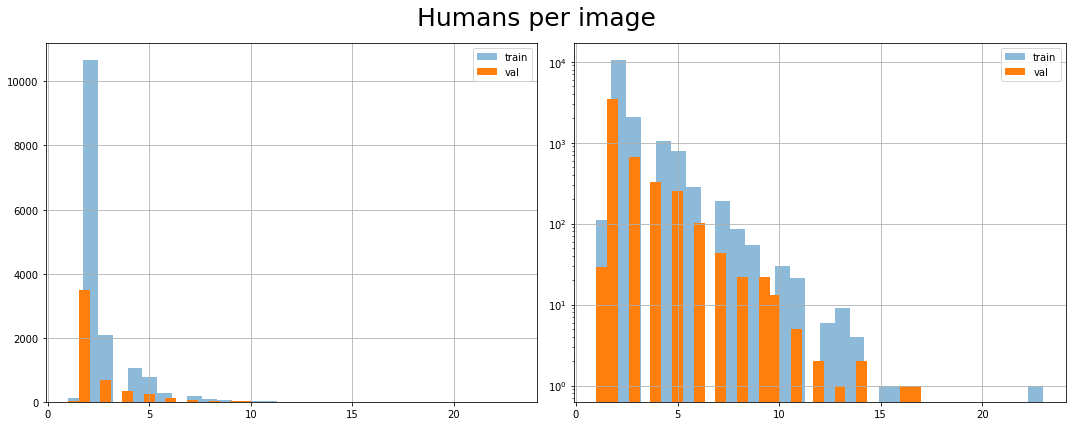

In [140]:
num_train = df_train.groupby('image_id').count()['num_kps']
num_val = df_val.groupby('image_id').count()['num_kps']

plt.figure(figsize=(15, 6))

plt.subplot(1,2,1)
num_train.hist(bins=30, alpha=0.5, label='train')
num_val.hist(bins=30, label='val')
plt.legend();

plt.subplot(1,2,2)
num_train.hist(bins=30, alpha=0.5, label='train')
num_val.hist(bins=30, label='val')

plt.yscale('log')
plt.legend();

plt.suptitle('Humans per image', fontsize=25)
plt.tight_layout();

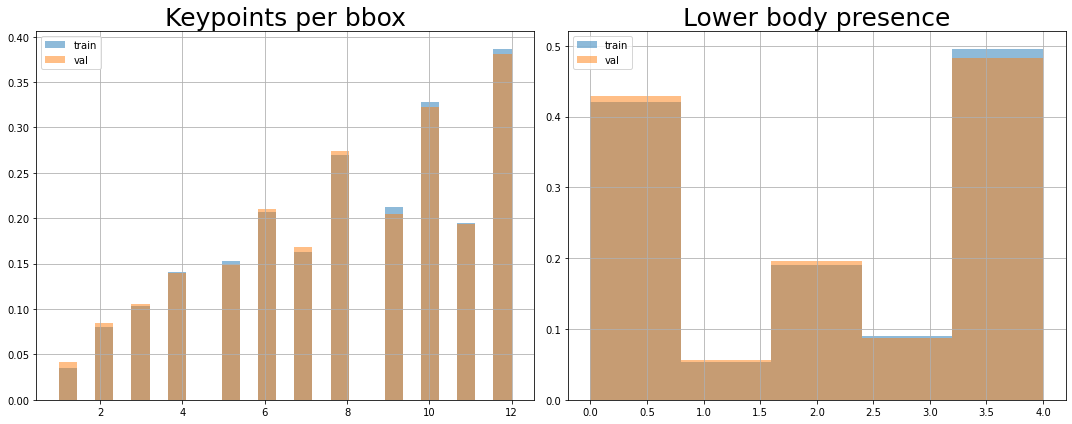

In [141]:
plt.figure(figsize=(15, 6))

plt.subplot(1,2,1)
df_train.num_kps.hist(bins=25, density=True, alpha=0.5, label='train')
df_val.num_kps.hist(bins=25, density=True, alpha=0.5, label='val')
plt.title('Keypoints per bbox', fontsize=25)
plt.legend();

plt.subplot(1,2,2)
df_train.num_lower_kps.hist(bins=5, density=True, alpha=0.5, label='train')
df_val.num_lower_kps.hist(bins=5, density=True, alpha=0.5, label='val')
plt.title('Lower body presence', fontsize=25)
plt.legend();

plt.tight_layout();

Loading and preparing results...
DONE (t=0.27s)
creating index...
index created!


  0%|          | 0/13148 [00:00<?, ?it/s]

----------------------------------------
Number of images: 4995
Number of humans: 13148, 2.6322322322322322 per image
Number of keypoints per human: 8.174247033769394
How many is upper_body only: 0.34507149376331003


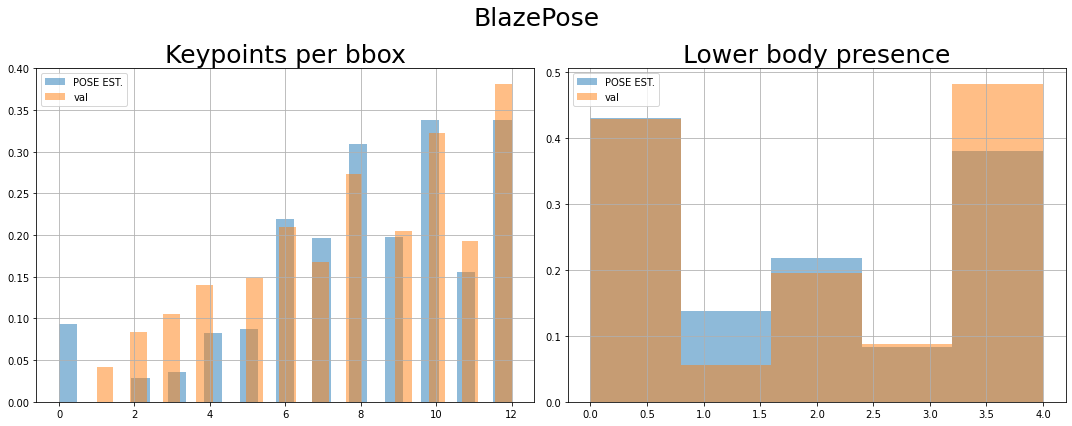

In [142]:
coco_res = coco_val.loadRes('../data/outputs/val_GT-detection_BP-0.5-pose.json')
df = process_coco(coco_res)
n_images = len(df.image_id.unique())
n_humans = len(df)

print('--'*20)
print(f'Number of images: {n_images}')
print(f'Number of humans: {n_humans}, {n_humans/n_images} per image')

print(f'Number of keypoints per human: {df.num_kps.mean()}')
print(f'How many is upper_body only: {sum(df.num_lower_kps == 0) / n_humans}')

plt.figure(figsize=(15, 6))

plt.subplot(1,2,1)
df.num_kps.hist(bins=25, density=True, alpha=0.5, label='POSE EST.')
df_val.num_kps.hist(bins=25, density=True, alpha=0.5, label='val')
plt.title('Keypoints per bbox', fontsize=25)
plt.legend();

plt.subplot(1,2,2)
df.num_lower_kps.hist(bins=5, density=True, alpha=0.5, label='POSE EST.')
df_val.num_lower_kps.hist(bins=5, density=True, alpha=0.5, label='val')
plt.title('Lower body presence', fontsize=25)
plt.legend();

plt.suptitle('BlazePose', fontsize=25)
plt.tight_layout();

# любит докидывать лишних точек (occlusion), слабый на малом количестве точек (ансамбль)